# WhatsApp Group Chats Analysis
Messaging apps have become an integral part of our daily communication, and WhatsApp is undoubtedly one of the most popular messaging apps in the world. But have you ever wondered what insights can be gained from analyzing your WhatsApp chat history? With the help of Python and some data analysis techniques, we can extract valuable information such as most active chat participants, popular discussion topics, and even sentiment analysis of the conversations. In this notebook, we'll dive into how to perform WhatsApp chat analysis using Python and explore the exciting insights that can be gained from your own chat history.

## Packages and Libraries
I’ll be utilizing various libraries and packages, such as Pandas, Matplotlib, and NLTK, which can help with tasks such as data manipulation, visualization, and natural language processing. Therefore, before diving into the analysis, it’s important to make sure these libraries are installed and imported correctly.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='white')
import plotly.express as px

import re
from collections import Counter
import emoji
import collections
import datetime
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

## Loading text data and transfroming to a dataframe
Once we have the text file containing the exported WhatsApp chat data, we can create a Pandas DataFrame in Python to organize the data in a structured format. This will allow us to easily manipulate and analyze the chat data using various Python libraries and techniques.

In [2]:
# Read chat data from text file
with open('WhatsApp Chat with CPE 300L.txt', 'r', encoding='utf-8') as f:
    chat_data = f.readlines()

# Define regular expressions to extract data
message_regex = re.compile(r'^(\d{2}\/\d{2}\/\d{4}, \d{2}:\d{2}) - ([^:]+): (.+)$')
system_message_regex = re.compile(r'^(\d{2}\/\d{2}\/\d{4}, \d{2}:\d{2}) - (.+)$')
media_message_regex = re.compile(r'^(\d{2}\/\d{2}\/\d{4}, \d{2}:\d{2}) - ([^:]+) attached (\S+) \(.*\)$')

# Initialize data lists
dates = []
times = []
members = []
messages = []
message_types = []
message_lengths = []
reaction_counts = []
word_counts = []
hashtags = []
mentions = []
emojis = []

# Loop through chat data and extract required information
for line in chat_data:
    # Check if line contains a message
    match = message_regex.match(line)
    if match:
        dates.append(match.group(1)[:10])
        times.append(match.group(1)[11:])
        member = emoji.demojize(match.group(2)).strip()
        members.append(member)
        messages.append(match.group(3))
        message_types.append('text')
        message_lengths.append(len(match.group(3)))
        reaction_counts.append(0)
        word_counts.append(len(match.group(3).split()))
        hashtags.append(re.findall(r'#(\w+)', match.group(3)))
        mentions.append(re.findall(r'@(\w+)', match.group(3)))
        emojis.append(re.findall(r'[\U0001F600-\U0001F650]', match.group(3)))
    else:
        # Check if line contains a system message
        match = system_message_regex.match(line)
        if match:
            dates.append(match.group(1)[:10])
            times.append(match.group(1)[11:])
            members.append('System')
            messages.append(match.group(2))
            message_types.append('system')
            message_lengths.append(len(match.group(2)))
            reaction_counts.append(0)
            word_counts.append(len(match.group(2).split()))
            hashtags.append([])
            mentions.append([])
            emojis.append([])
        else:
            # Check if line contains a media message
            match = media_message_regex.match(line)
            if match:
                dates.append(match.group(1)[:10])
                times.append(match.group(1)[11:])
                member = emoji.demojize(match.group(2)).strip()
                members.append(member)
                messages.append(match.group(3))
                message_types.append('media')
                message_lengths.append(0)
                reaction_counts.append(0)
                word_counts.append(0)
                hashtags.append([])
                mentions.append([])
                emojis.append([])

# Create pandas dataframe from extracted data
df = pd.DataFrame({
    'date': dates,
    'time': times,
    'member': members,
    'message': messages,
    'message_type': message_types,
    'message_length': message_lengths,
    'reaction_count': reaction_counts,
    'word_count': word_counts,
    'hashtags': hashtags,
    'mentions': mentions,
    'emojis': emojis
})
df.shape

(24318, 11)

## Loading the dataframe

In [4]:
df.head(10)

,date,time,member,message,message_type,message_length,reaction_count,word_count,hashtags,mentions,emojis
0,03/07/2021,22:11,System,Messages and calls are end-to-end encrypted. N...,system,139,0,25,[],[],[]
1,07/10/2021,12:09,ViNe:keycap_6::keycap_9:,😭😭,text,2,0,1,[],[],"[😭, 😭]"
2,08/01/2022,22:13,Lolu,I soft Abi I no soft?,text,21,0,6,[],[],[]
3,18/04/2022,16:05,+234 816 440 8811,<Media omitted>,text,15,0,2,[],[],[]
4,22/04/2022,21:00,+234 816 440 8811,<Media omitted>,text,15,0,2,[],[],[]
5,05/06/2022,10:07,System,Kingsley added Dapo,system,19,0,3,[],[],[]
6,05/06/2022,12:13,Kingsley,<Media omitted>,text,15,0,2,[],[],[]
7,05/06/2022,12:13,Kingsley,God bless you,text,13,0,3,[],[],[]
8,05/06/2022,12:32,Abraham,@2347060487721 why this🥲,text,24,0,3,[],[2347060487721],[]
9,05/06/2022,12:32,Abraham,Happy birthday @2349021287530,text,29,0,3,[],[2349021287530],[]


## Exploratory Data Analysis

I’m going to drop some rows as they are irrelevant to the analysis.

In [5]:
df.drop([0, 1, 2, 3, 4], axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

In [7]:
df['member'].unique()

array(['System', 'Kingsley', 'Abraham', 'Dapo', 'Victor',
       'Queen Lizzy :princess:', 'Lolu', 'Nerry Kylen',
       'Ahmed Abubakar:face_with_medical_mask:', 'Fulfillment',
       '+234 816 440 8811', 'Aishort', 'Jerry',
       'ViNe:keycap_6::keycap_9:', 'Edward', 'Real John :soccer_ball:',
       'Scholar Sammy', '+234 814 086 1402', 'Tosin', 'Lanre', 'Neemah',
       '+234 708 310 7624', 'Khaleesi:crown::princess:',
       'Ayotunde Martins', 'Ifeoluwa', 'Abdulrahman :glasses:', 'AY',
       'Augustine :soccer_ball:', 'Alexis', 'Kenny Habeeb', 'Abdulraqib',
       'Nelson Isralia', 'Afolabi', 'Peace :face_with_medical_mask:',
       'Dami', 'Ebenezer', '+234 902 750 9390', 'Mayowa Solomon',
       '+234 802 089 7107', 'Blurryface:smiling_face_with_sunglasses:',
       'Rasheed', 'Mario', 'Awwal', 'Abdulmuiz', 'Keem', 'Owen',
       'TheRealAyo', 'Emprazzy', 'Soft Emeka', 'Femi Clinton', 'Lawal',
       'Mohammed', 'Temidayo', '+234 703 585 0700', 'Jamiu',
       '+234 706 464 1

Some of the members’ name are incorrect. I will make changes to this.

In [8]:
# rename incorrect member names

replace_dict = {
    'System': 'System messages',
    'Queen Lizzy :princess:': 'Queen Lizzy',
    'Ahmed Abubakar:face_with_medical_mask:': 'Ahmed',
    'Aishort': 'Aisha',
    'ViNe:keycap_6::keycap_9:': 'ViNe 69',
    'Real John :soccer_ball:': 'John',
    '+234 816 440 8811': 'Abdulmalik',
    '+234 708 310 7624': 'Inioluwa',
    'Khaleesi:crown::princess:': 'Khaleesi',
    'Abdulrahman :glasses:': 'Abdulrahman',
    'Ayotunde Martins': 'Martins',
    'Augustine :soccer_ball:': 'Augustine',
    'Kenny Habeeb': 'Kenny',
    'Abdulraqib': 'Raqib',
    'Peace :face_with_medical_mask:': 'Peace',
    'Nelson Isralia': 'Nelson',
    'Dami': 'Dammy',
    'Mayowa Solomon': 'Mayowa',
    'Blurryface:smiling_face_with_sunglasses:': 'Blurryface',
    'Femi Clinton': 'Femi',
    '+234 816 892 3626': 'Abdulbasit',
    'Scholar Mukhtar': 'Mukhtar',
    '+234 701 897 1552': 'Maryam',
    'Nerry Kylen': 'Nerry'
}
df['member'] = df['member'].replace(replace_dict)

Now let's check them again.

In [9]:
df['member'].unique()

array(['System messages', 'Kingsley', 'Abraham', 'Dapo', 'Victor',
       'Queen Lizzy', 'Lolu', 'Nerry', 'Ahmed', 'Fulfillment',
       'Abdulmalik', 'Aisha', 'Jerry', 'ViNe 69', 'Edward', 'John',
       'Scholar Sammy', '+234 814 086 1402', 'Tosin', 'Lanre', 'Neemah',
       'Inioluwa', 'Khaleesi', 'Martins', 'Ifeoluwa', 'Abdulrahman', 'AY',
       'Augustine', 'Alexis', 'Kenny', 'Raqib', 'Nelson', 'Afolabi',
       'Peace', 'Dammy', 'Ebenezer', '+234 902 750 9390', 'Mayowa',
       '+234 802 089 7107', 'Blurryface', 'Rasheed', 'Mario', 'Awwal',
       'Abdulmuiz', 'Keem', 'Owen', 'TheRealAyo', 'Emprazzy',
       'Soft Emeka', 'Femi', 'Lawal', 'Mohammed', 'Temidayo',
       '+234 703 585 0700', 'Jamiu', '+234 706 464 1737', 'Easyoffing',
       'Abdulbasit', '+234 814 220 6459', 'Sadiq', 'Mukhtar', 'Marshall',
       '+234 813 919 7668', 'Derin', '+234 813 027 3824', 'Maryam',
       'Integral', 'Muhammad Otun', 'Nabeelah', 'Emma Adegboye',
       '+234 915 417 2274', '+234 905 711 8

## Quick Stats.

In [119]:
def split_count(text):

    emoji_list = []
    data = re.findall(r'[^\s\u1f300-\u1f5ff]', text)
    for word in data:
        if any(char in emoji.distinct_emoji_list(text) for char in word):
            emoji_list.append(word)

    return emoji_list

total_messages = df.shape[0]
avg_message_length = df['message_length'].mean()
media_messages = df[df['message'] == '<Media omitted>'].shape[0]
df["emoji"] = df["message"].apply(split_count)
emojis = sum(df['emoji'].str.len())
URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()
links = np.sum(df.urlcount)

print("Stats")
print("Messages:", total_messages)
print('Average message length:', avg_message_length)
print("Media messages:", media_messages)
print("Emojis:", emojis)
print("Links:", links)

Stats
Messages: 24313
Average message length: 22.208982848681774
Media messages: 7164
Emojis: 8253
Links: 32


Messages sent messages sent per member, words per message
emojis sent per message links sent per message and other stats.

In [18]:
# Calculate messages sent per member
messages_sent = df.groupby('member')['message'].count()

# Calculate words per message
df['words_per_message'] = df['message'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
words_per_message = df.groupby('member')['words_per_message'].mean()

# Calculate emojis sent per message
df['emojis_per_message'] = df['emojis'].apply(lambda x: len(x) if isinstance(x, str) else 0)
emojis_per_message = df.groupby('member')['emojis_per_message'].mean()

# Calculate links sent per message
df['links_per_message'] = df['message'].apply(lambda x: len(re.findall(r'http\S+', x)) if isinstance(x, str) else 0)
links_per_message = df.groupby('member')['links_per_message'].mean()

# Combine stats into a single dataframe
stats_df = pd.concat([messages_sent, words_per_message, emojis_per_message, links_per_message], axis=1)
stats_df.columns = ['messages_sent', 'words_per_message', 'emojis_per_message', 'links_per_message']

# Sort by messages sent in descending order
stats_df = stats_df.sort_values('messages_sent', ascending=False)

# Print results
stats_df

,messages_sent,words_per_message,emojis_per_message,links_per_message
member,,,,
Kingsley,4666,3.499571,0.0,0.000643
Tosin,4303,3.256565,0.0,0.000000
Lolu,2238,5.106345,0.0,0.001340
Ahmed,1106,3.176311,0.0,0.000000
Fulfillment,1051,3.868696,0.0,0.000000
...,...,...,...,...
Emma Adegboye,6,2.666667,0.0,0.000000
Nelson,3,6.666667,0.0,0.000000
Nabeelah,2,2.000000,0.0,0.000000


## Frequently used words.
Most commonly used words in the group.

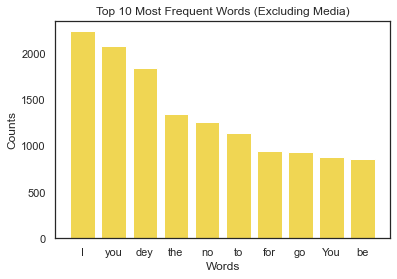

In [99]:
# Filter out messages that contain media files
non_media = df[~df['message'].str.contains('<Media omitted>')]

# Extract all messages from the DataFrame and join them into a single string
all_messages = ' '.join(non_media['message'].astype(str).tolist())

# Convert the string into a list of words
all_words = all_messages.split()

# Count the frequency of each word using Python's Counter object
word_freq = Counter(all_words)

# Select the top 10 most frequent words and their counts
top_words = word_freq.most_common(10)

# Extract the words and counts into separate lists
words = [word[0] for word in top_words]
counts = [count[1] for count in top_words]

# Create a bar chart of the top 10 most frequent words
plt.bar(words, counts, color='#F0D653')
plt.title('Top 10 Most Frequent Words (Excluding Media)')
plt.xlabel('Words')
plt.ylabel('Counts')
plt.show()

## Emojis.
In addition to words, I included emojis to gain insights into the most frequently used emojis and their corresponding meanings in the WhatsApp chat.

Frequency of emojis

In [32]:
total_emojis_list = list([a for b in df.emojis for a in b])
emoji_dict = dict(collections.Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)

emoji_df = pd.DataFrame(emoji_dict, columns=['Emoji', 'Frequency'])
emoji_df

,Emoji,Frequency
0,😂,4475
1,😭,1319
2,😹,296
3,😌,127
4,😅,62
5,🙇,61
6,🙏,59
7,🙂,55
8,🙌,47
9,😒,46


Distribution of emojis

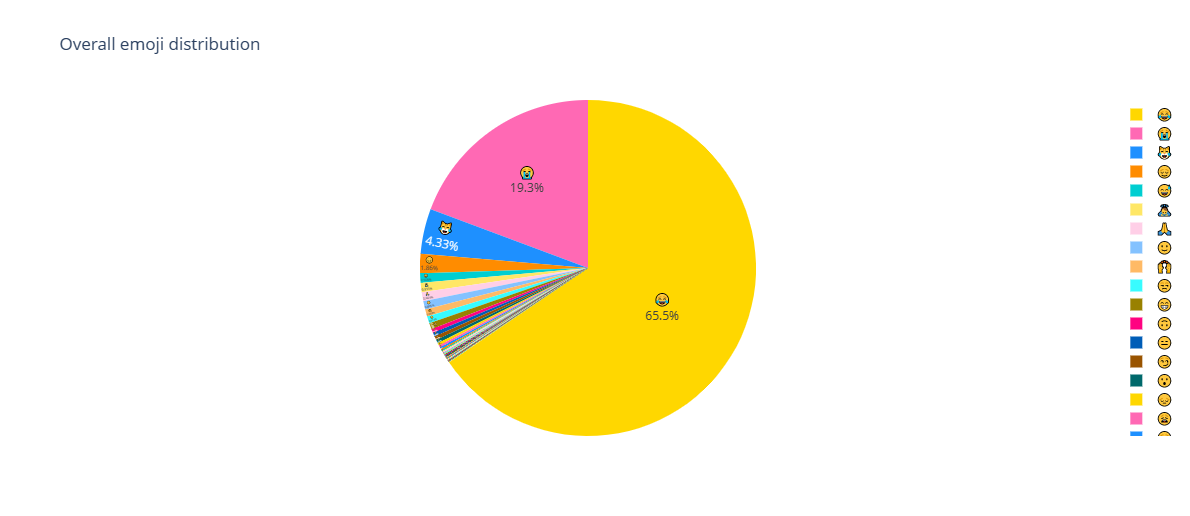

In [48]:
# Define custom colors for the pie chart
colors = ['#ffd700', '#ff69b4', '#1e90ff', '#ff8c00', '#00ced1']

# Create a pie chart of the emoji frequencies with custom colors
fig = px.pie(emoji_df, values='Frequency', names='Emoji', title='Overall emoji distribution', color_discrete_sequence=colors)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(width=800, height=500, showlegend=True)

# Show the plot
fig.show();

## Word Cloud.

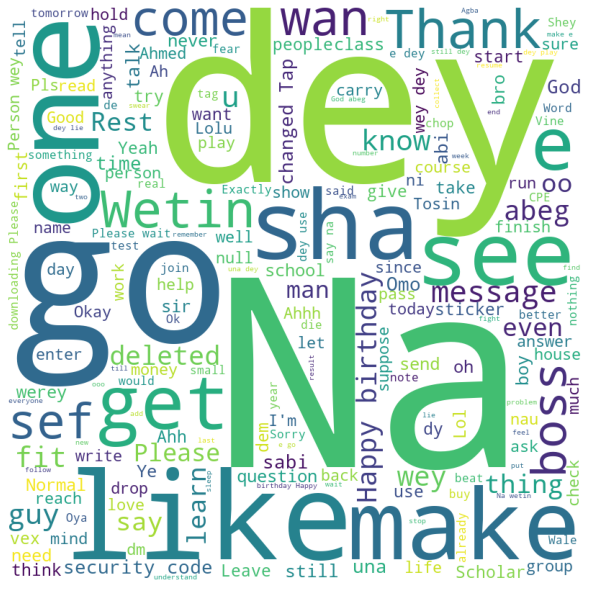

In [69]:
# Remove messages containing "Media omitted"
x = df[~df['message'].str.contains('Media omitted')]

# Concatenate all cleaned messages into a single string
all_messages = x['message'].dropna().str.cat(sep=' ')

# Generate word cloud
wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      stopwords=STOPWORDS,
                      min_font_size=10).generate(all_messages)

# Plot word cloud
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [49]:
# # Remove messages containing "Media omitted"
# x = df[~df['message'].str.contains('Media omitted')]

# # Concatenate all cleaned messages into a single string
# all_messages = x['message'].dropna().str.cat(sep=' ')

# # Generate word cloud
# wordcloud = WordCloud(width=800, height=800,
#                       background_color='#273456', 
#                       color_func=lambda *args, **kwargs: '#F0D753',
#                       stopwords=STOPWORDS,
#                       min_font_size=10).generate(all_messages)

# # Plot word cloud
# plt.figure(figsize=(20,5))
# plt.imshow(wordcloud)
# plt.axis("off")
# plt.tight_layout(pad=0)
# plt.show()

## Most Active dates.

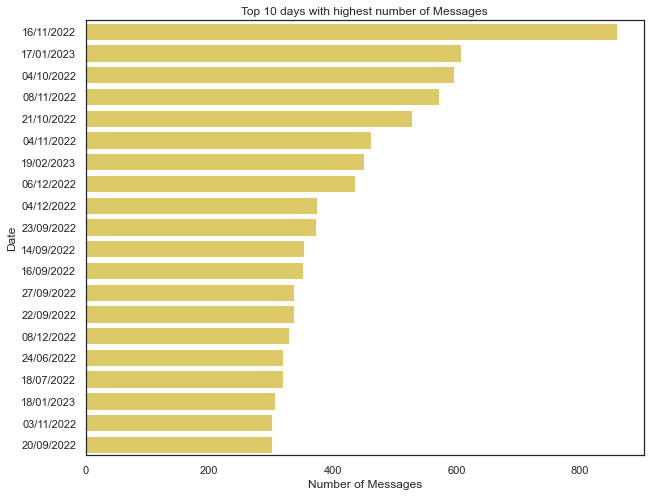

In [65]:
plt.figure(figsize=[10, 8])
sns.barplot(x='count', y='date', data=df['date'].value_counts().head(20).reset_index().rename(columns={'index':'date', 'date':'count'}), color='#F0D653')
plt.title('Top 10 days with highest number of Messages')
plt.xlabel('Number of Messages')
plt.ylabel('Date')
plt.show()

## Most Active times.

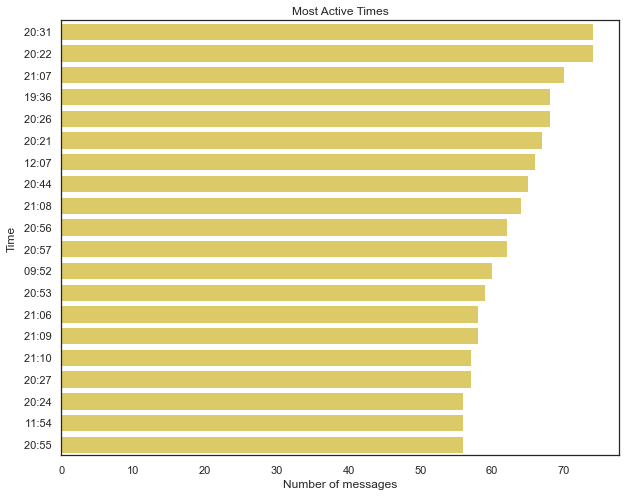

In [68]:
plt.figure(figsize=[10, 8])
sns.barplot(x='count', y='time', data=df['time'].value_counts().head(20).reset_index().rename(columns={'index':'time', 'time':'count'}), color='#F0D653')
plt.title('Most Active Times')
plt.xlabel('Number of messages')
plt.ylabel('Time')
plt.show();

## Most Active hour of the day.

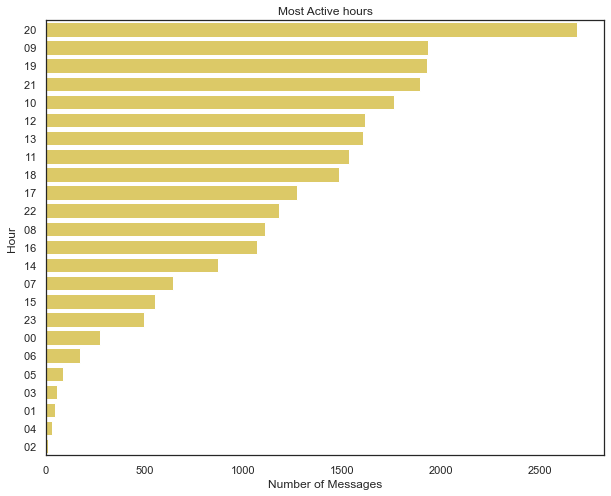

In [87]:
# Extract the hour from the time column
df['hour'] = df['time'].str.split(':', expand=True)[0]

# Plot the most active hours
plt.figure(figsize=[10, 8])
sns.barplot(x='count', y='hour', data=df['hour'].value_counts().reset_index().rename(columns={'index':'hour', 'hour':'count'}), color='#F0D653')
plt.title('Most Active hours')
plt.xlabel('Number of Messages')
plt.ylabel('Hour')
plt.show()

## Most Active days of the week.

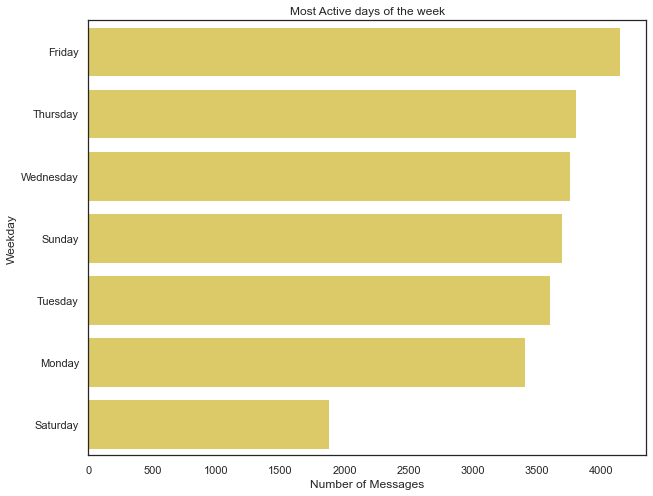

In [89]:
# Extract the weekday from the date column
df['weekday'] = df['date'].dt.day_name()

# Plot the most active hours
plt.figure(figsize=[10, 8])
sns.barplot(x='count', y='weekday', data=df['weekday'].value_counts().reset_index().rename(columns={'index':'weekday', 'weekday':'count'}), color='#F0D653')
plt.title('Most Active days of the week')
plt.xlabel('Number of Messages')
plt.ylabel('Weekday')
plt.show()

## Most active and least active group participants.

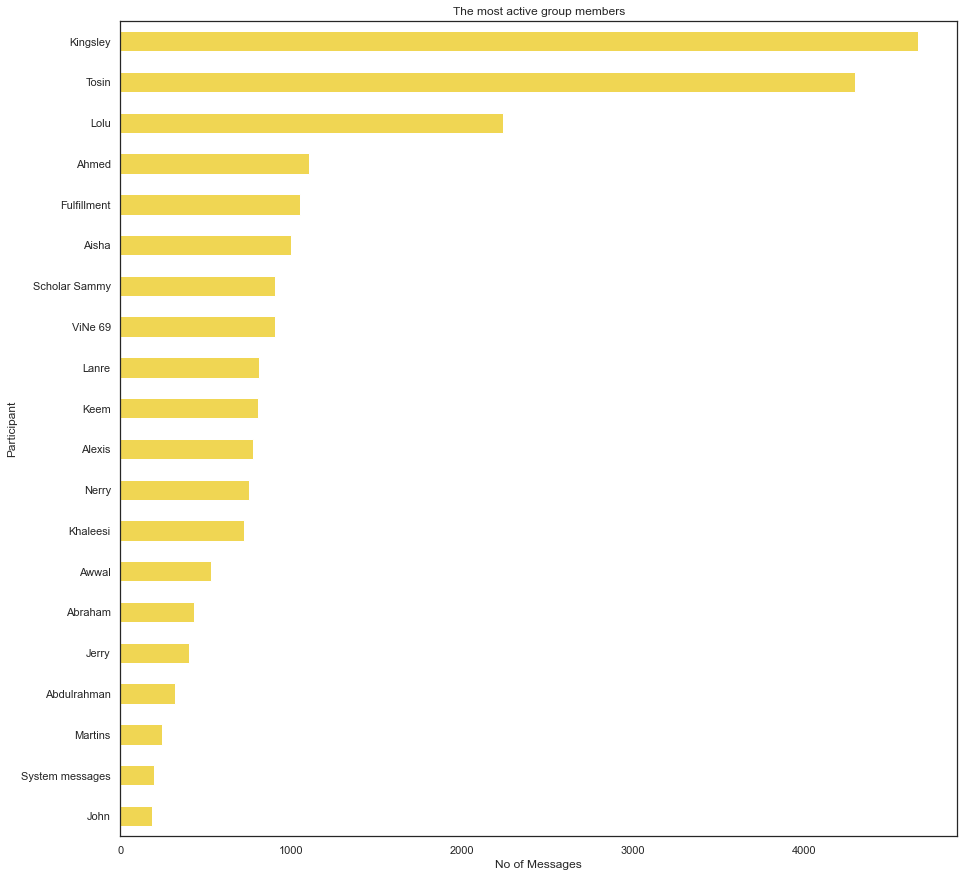

In [95]:
df['member'].value_counts().head(20).sort_values(ascending=True).plot(kind='barh',figsize=(15,15), color='#F0D653')
plt.title('The most active group members')
plt.ylabel('Participant')
plt.xlabel('No of Messages');

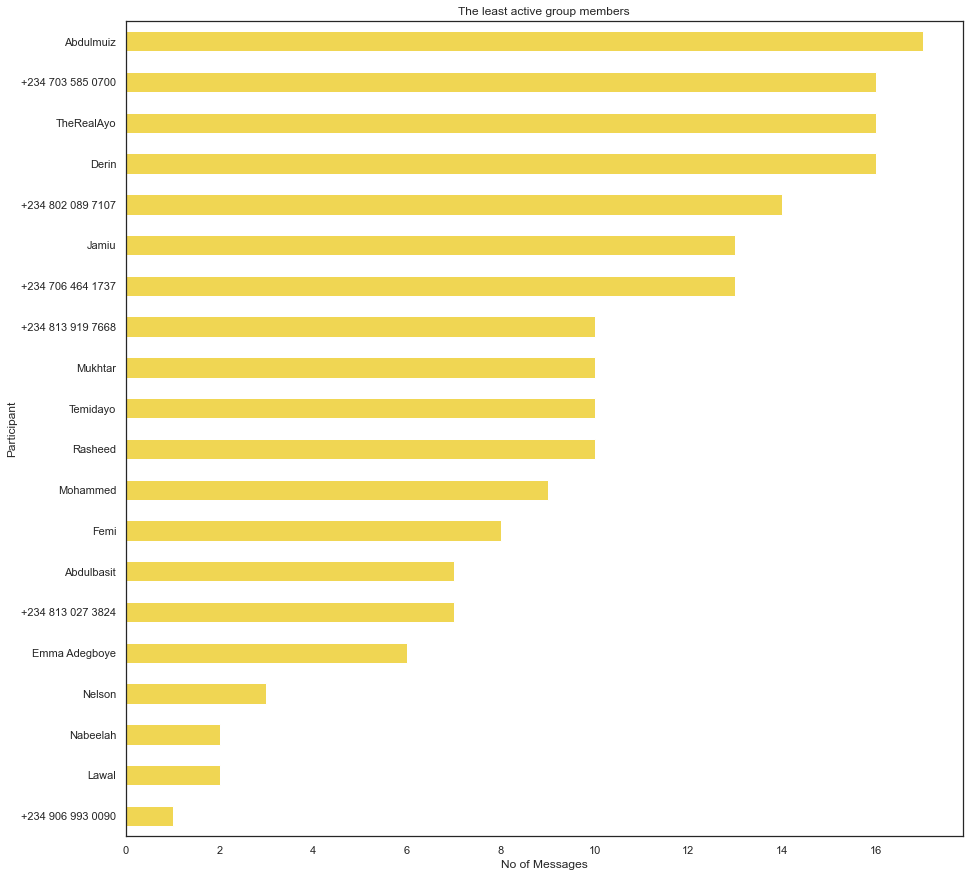

In [97]:
df['member'].value_counts().tail(20).sort_values(ascending=True).plot(kind='barh',figsize=(15,15), color='#F0D653')
plt.title('The least active group members')
plt.ylabel('Participant')
plt.xlabel('No of Messages');

## Messaging progression
Taking a closer look at how messaging has evolved and what it means for the daily interactions.

C:\Users\user\AppData\Local\Temp\ipykernel_7952\1476495519.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



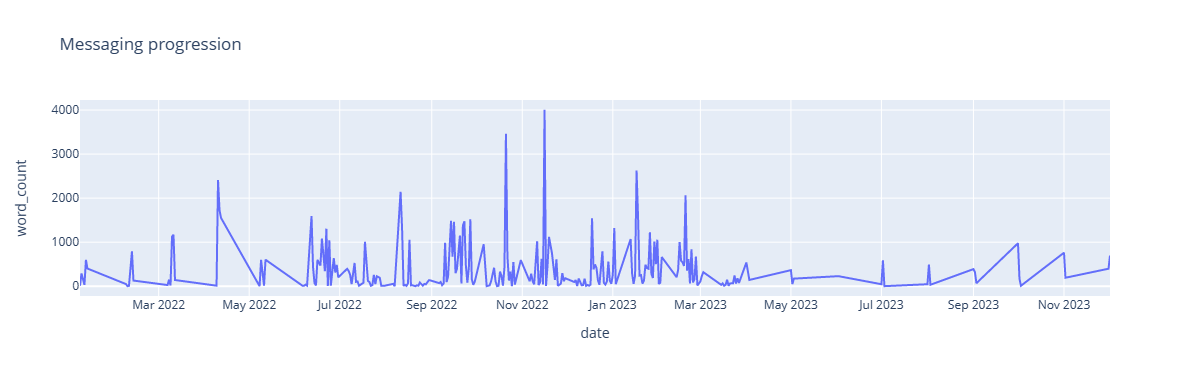

In [115]:
date_df = df.groupby("date").sum()
date_df.reset_index(inplace=True)
fig = px.line(date_df, x="date", y="word_count", title='Messaging progression')
fig.update_xaxes(nticks=20)
fig.show()

As we wrap up this analysis of the WhatsApp group chat, it’s clear that messaging has come a long way and continues to evolve. Through the analysis, we gained insights into the group’s communication patterns, trends, and habits, revealing a fascinating look at how we communicate in today’s digital age.

But what does this all mean for our future interactions? As we continue to rely on messaging as a primary mode of communication, it’s essential to understand how our habits are changing and what they might look like in the future. With the power of data analysis, we can uncover these insights and use them to improve our communication, both online and offline.

Overall, this analysis of a WhatsApp group chat serves as a reminder of the power of data and what it can reveal about our daily interactions. By continuing to explore and analyze our communication habits, we can gain valuable insights into ourselves and our relationships, ultimately leading to more meaningful and effective conversations in the future.